## Import Library

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import random
import math
from typing import List, Tuple, Union, Callable

##Make My Tree(graph)

In [87]:
class Node:
    def __init__(self, value: str, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

#This is genetic algorythm

In [88]:
class GeneticProgramming:
    def __init__(self,
                 population_size: int = 100,
                 max_depth: int = 5,
                 tournament_size: int = 5):
        self.population_size = population_size
        self.max_depth = max_depth
        self.tournament_size = tournament_size

        self.binary_operators = ['+', '-', '*', '/']
        self.unary_operators = ['sin', 'cos', 'sqrt']
        self.terminals = ['x'] + [str(i) for i in range(-5, 6)]


    def evaluate_tree(self, node, x):
        if node is None:
            return 0

        # constant or variable
        if isinstance(node.value, (int, float)):
            return float(node.value)
        elif node.value == 'x':
            return x

        # Unary operators
        elif node.value == 'sqrt':
            return math.sqrt(max(0, self.evaluate_tree(node.left, x)))
        elif node.value == 'sin':
            return math.sin(self.evaluate_tree(node.left, x))
        elif node.value == 'cos':
            return math.cos(self.evaluate_tree(node.left, x))

        # Binary operators
        elif node.value == '+':
            return self.evaluate_tree(node.left, x) + self.evaluate_tree(node.right, x)
        elif node.value == '-':
            return self.evaluate_tree(node.left, x) - self.evaluate_tree(node.right, x)
        elif node.value == '*':
            return self.evaluate_tree(node.left, x) * self.evaluate_tree(node.right, x)
        elif node.value == '/':
            right_val = self.evaluate_tree(node.right, x)
            return (self.evaluate_tree(node.left, x) / right_val) if right_val != 0 else 0

        # we can't use bew command
                # elif node.value == '%':
                #     right_val = self.evaluate_tree(node.right, x) % left_val
                #     return (self.evaluate_tree(node.left, x) % right_val) if right_val != 0 else 0
                # elif node.value == '^':
                # return self.evaluate_tree(node.left, x) ** self.evaluate_tree(node.right, x)
                # make nan tree when use tavan


    def create_random_tree(self, depth: int) :
        if depth == 0 or (depth < self.max_depth and random.random() < 0.3):
            return Node(random.choice(self.terminals))

        if random.random() < 0.7:
            operator = random.choice(self.binary_operators)
            left = self.create_random_tree(depth - 1)
            right = self.create_random_tree(depth - 1)
            node = Node(operator, left, right)
        else:
            operator = random.choice(self.unary_operators)
            left = self.create_random_tree(depth - 1)
            node = Node(operator, left)

        return node

    def fitness(self, node: Node, X: np.ndarray, y: np.ndarray):
        try:
            predictions = np.array([self.evaluate_tree(node, x) for x in X])

            if np.any(np.abs(predictions) > 1e10) or np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                return float('-inf')

            mse = np.mean((predictions - y) ** 2)
            if np.isnan(mse) or np.isinf(mse):
                return float('-inf')

            return -mse
        except:
            return float('-inf')

    def tournament_selection(self, population: List[Node], fitnesses: List[float]):
        tournament_idx = random.sample(range(len(population)), self.tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_idx]
        winner_idx = tournament_idx[np.argmax(tournament_fitnesses)]
        return deepcopy(population[winner_idx])

    def crossover(self, parent1: Node, parent2: Node):
        if random.random() < 0.5:
            return deepcopy(parent2), deepcopy(parent1)

        new_parent1 = deepcopy(parent1)
        new_parent2 = deepcopy(parent2)

        if random.random() < 0.5 and new_parent1.left:
            new_parent1.left, new_parent2.left = new_parent2.left, new_parent1.left
        elif new_parent1.right:
            new_parent1.right, new_parent2.right = new_parent2.right, new_parent1.right

        return new_parent1, new_parent2

    def mutate(self, node: Node) -> Node:
        if random.random() < 0.1:
            return self.create_random_tree(random.randint(1, self.max_depth))

        if node.left:
            node.left = self.mutate(node.left)
        if node.right:
            node.right = self.mutate(node.right)

        return node

    def train(self, X: np.ndarray, y: np.ndarray, generations: int = 50) -> Tuple[Node, List[float]]:
        population = [self.create_random_tree(self.max_depth) for _ in range(self.population_size)]
        best_fitness_history = []
        avg_fitness_history = []
        best_individual = None
        best_fitness = float('-inf')

        for gen in range(generations):
            fitnesses = [self.fitness(ind, X, y) for ind in population]

            gen_best_idx = np.argmax(fitnesses)
            gen_best_fitness = fitnesses[gen_best_idx]

            if gen_best_fitness > best_fitness:
                best_fitness = gen_best_fitness
                best_individual = deepcopy(population[gen_best_idx])

            best_fitness_history.append(-gen_best_fitness)
            avg_fitness_history.append(-np.mean([f for f in fitnesses if f != float('-inf')]))

            new_population = [deepcopy(population[gen_best_idx])]

            while len(new_population) < self.population_size:
                parent1 = self.tournament_selection(population, fitnesses)
                parent2 = self.tournament_selection(population, fitnesses)

                child1, child2 = self.crossover(parent1, parent2)

                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.extend([child1, child2])

            population = new_population[:self.population_size]

            if (gen + 1) % 10 == 0:
                print(f"Generation {gen + 1}/{generations}, Best MSE: {-best_fitness:.6f}")

        return best_individual, best_fitness_history, avg_fitness_history

    def plot_results(self, X: np.ndarray, y: np.ndarray, best_individual: Node,
                    best_fitness_history: List[float], avg_fitness_history: List[float]):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        predictions = np.array([self.evaluate_tree(best_individual, x) for x in X])
        sns.light_palette("seagreen", as_cmap=True)
        sns.scatterplot(x=X, y=y, ax=ax1, label='Actual', alpha=0.6,color='red')
        sns.lineplot(x=X, y=predictions, ax=ax1, color='purple', label='Predicted',marker="P")
        ax1.set_title('Actual vs Predicted')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')

        generations = range(1, len(best_fitness_history) + 1)
        sns.lineplot(x=generations, y=best_fitness_history, ax=ax2, label='Best MSE',color='brown')
        sns.lineplot(x=generations, y=avg_fitness_history, ax=ax2, label='Average MSE',color='black')
        ax2.set_title('Training History')
        ax2.set_xlabel('Generation')
        ax2.set_ylabel('Mean Squared Error')
        ax2.set_yscale('linear')

        plt.tight_layout()
        plt.show()


    def print_tree(self, node: Node, level: int = 0):
        if node is None:
            return ""

        indent = "    " * level

        result = f"{indent}├── {node.value}\n"

        if node.left:
            result += self.print_tree(node.left, level + 1)
        if node.right:
            result += self.print_tree(node.right, level + 1)

        return result

    def visualize_expression(self, node: Node) -> None:
        print("Expression Tree:")
        print(self.print_tree(node))

# def target_function(x):
#     return x**2+1 #+ np.sin(x) + 5

# X = np.linspace(-5, 5, 100)
# y = target_function(X)

# gp = GeneticProgramming(population_size=100, max_depth=4)
# best_individual, best_fitness_history, avg_fitness_history = gp.train(X, y, generations=100)
# gp.visualize_expression(best_individual)

# gp.plot_results(X, y, best_individual, best_fitness_history, avg_fitness_history)

## Plots

Generation 10/100, Best MSE: 131.475658
Generation 20/100, Best MSE: 131.475658
Generation 30/100, Best MSE: 131.475658
Generation 40/100, Best MSE: 131.475658
Generation 50/100, Best MSE: 131.475658
Generation 60/100, Best MSE: 125.334421
Generation 70/100, Best MSE: 125.334421
Generation 80/100, Best MSE: 1.000000
Generation 90/100, Best MSE: 1.000000
Generation 100/100, Best MSE: 1.000000


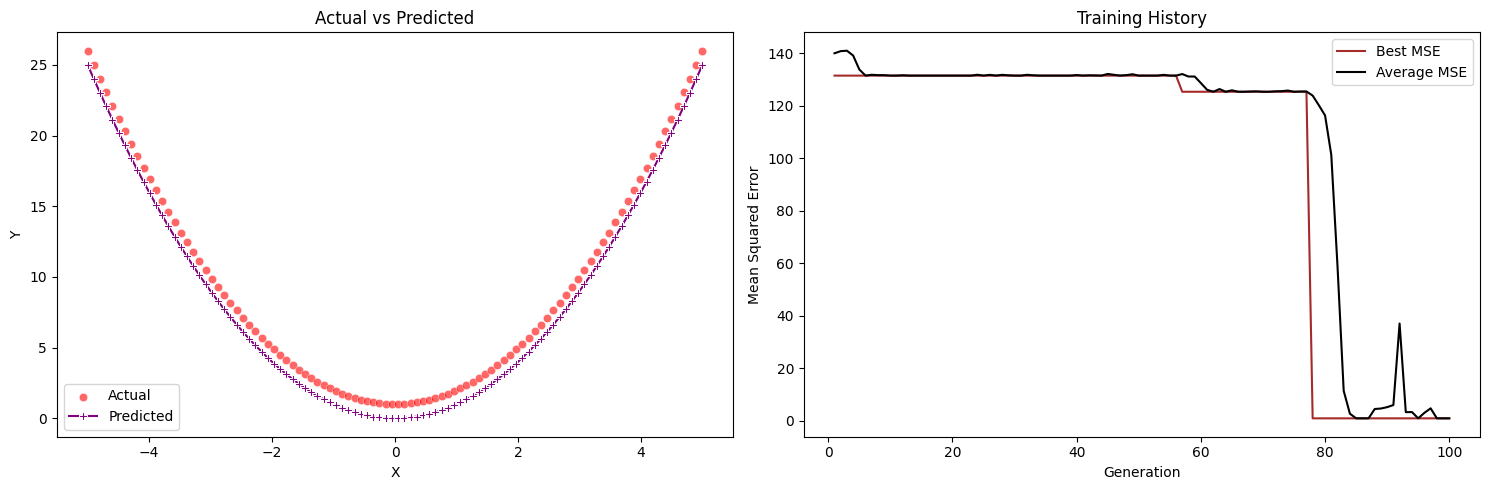

In [89]:
def target_function(x):
    return x**2+1 #+ np.sin(x) + 5

X = np.linspace(-5, 5, 100)
y = target_function(X)

gp = GeneticProgramming(population_size=100, max_depth=4)
best_individual, best_fitness_history, avg_fitness_history = gp.train(X, y, generations=100)

gp.plot_results(X, y, best_individual, best_fitness_history, avg_fitness_history)

## Tree of this code

In [90]:
gp.visualize_expression(best_individual)

Expression Tree:
├── *
    ├── x
    ├── x

